# Forecasting with Random Forest

This notebook demonstrates how to use a random forest regressor to forecast time series data. The inspiration behind my implementation of the ForestForecast is based on reference material from ArcGIS. (https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/learnmoreforestbasedforecast.htm)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
from forest_forecast.models import ForestForecast

## Generate Synthetic Data
We begin by creating some synthetic data for this demonstration.

In [3]:
date = datetime(2025, 3, 28)

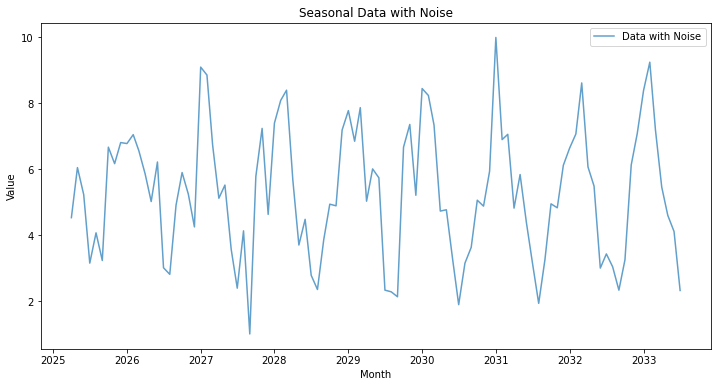

In [4]:
# Parameters
np.random.seed(13)  # For reproducibility
periods = 100
amplitude = 10  # Amplitude of the seasonal component
noise_level = 4  # Standard deviation of the Gaussian noise

# Create a date range for monthly data
dates = pd.date_range(date, periods=periods, freq='MS')

# Generate seasonal data with noise
noise = np.random.normal(0, noise_level, periods)
seasonal_data = amplitude * np.sin(2 * np.pi * dates.quarter / 4) + noise

# Normalize the data to be between 1 and 10
min_val = 1
max_val = 10
seasonal_data_normalized = (seasonal_data - seasonal_data.min()) / (seasonal_data.max() - seasonal_data.min()) * (max_val - min_val) + min_val

# Round to 2 decimal points
seasonal_data_normalized = np.round(seasonal_data_normalized, 2)

# Create a DataFrame
df = pd.DataFrame({
    'Month': dates.date,
    'Values': seasonal_data_normalized,
})

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Values'], label='Data with Noise', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Seasonal Data with Noise')
plt.legend()
plt.show()

## Train the Model Using Defaults
By default, the model will use spectral density to estimate the optimal season length. This length is passed as the ``time_step_window`` parameter. This parameter controls how many time steps are used as the set of explanatory or independent variables in the random forest regressor.

In [5]:
# We will split the time series using an 80-20 split
train = df.Values[:80]
test = df.Values[80:]

In [6]:
model = ForestForecast()

In [7]:
model.fit(train)

c:\Users\Jimmy\Documents\DataDive\forecast-with-trees\forest_forecast\utils.py:83: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1 / frequencies


ForestForecast(regressor_params={'random_state': 13}, time_step_window=11)

In [8]:
preds = model.predict(20)
preds

array([5.8487831 , 7.03630338, 8.35945674, 7.30958252, 6.31328799,
       5.56329105, 5.41202417, 3.39678982, 2.79570396, 3.12785243,
       4.49036707, 5.47944496, 5.45926771, 6.92064373, 8.30460508,
       7.50572722, 6.80681673, 5.52929707, 5.24928114, 3.34903756])

In [9]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 1.150


## Manually Select the Time Step Window

In [10]:
from forest_forecast.utils import get_spectral_density, plot_periodgram

In [11]:
frequencies, power_spectrum, periods = get_spectral_density(df.Values)

c:\Users\Jimmy\Documents\DataDive\forecast-with-trees\forest_forecast\utils.py:83: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1 / frequencies


The plot below shows that there is a minor signal at 4 months and around 12 months. However, the signal is the strongest at around 12 months.

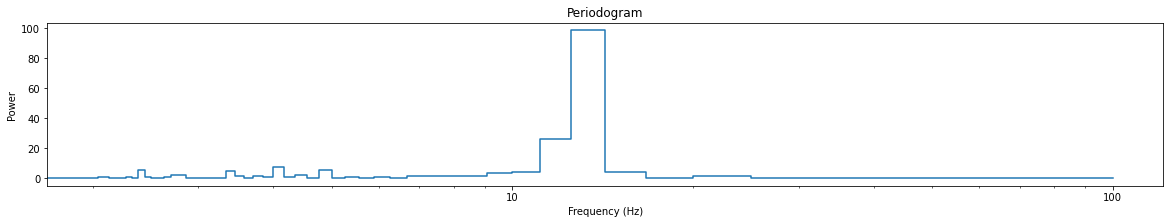

In [12]:
plot_periodgram(periods, power_spectrum)

### Use Time Step Window of 4 Months

In [13]:
model = ForestForecast(time_step_window=4)

In [14]:
model.fit(train)

ForestForecast(regressor_params={'random_state': 13}, time_step_window=4)

In [15]:
preds = model.predict(20)
preds

array([6.12452057, 7.1697567 , 7.16241559, 7.28431557, 7.14377199,
       7.0310008 , 6.8006106 , 6.47218726, 6.23054367, 5.71088415,
       5.27769885, 5.19514553, 5.41326026, 5.66916273, 5.60888973,
       5.69953634, 5.74461177, 5.48314859, 5.52453876, 5.74411422])

In [16]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 4.809


### Use Time Step Window of 12 Months

In [17]:
model = ForestForecast(time_step_window=12)

In [18]:
model.fit(train)

ForestForecast(regressor_params={'random_state': 13}, time_step_window=12)

In [19]:
preds = model.predict(20)
preds

array([6.03934325, 8.03612977, 8.46528804, 7.26745185, 6.08031685,
       5.42711435, 5.07313032, 2.98438186, 3.20172731, 2.9022058 ,
       5.49738119, 5.87401557, 5.46504437, 8.56182047, 8.24217138,
       8.00036094, 5.82783451, 5.52141364, 4.68589955, 2.80928608])

In [20]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 1.080


## Change the Forecast Approach
The default approach is to apply a first-order linear detrend on the time series. This allows us to predict for future values that may be outside of the range of values in the training set. However, you can also forecast with other approaches.
- Use "value" to predict only with the raw values. The important thing to note is that you shouldn't use this if you expect the values to increase or decrease in the future.
- Use "resid" to train the regressor to predict on the residuals. These residuals are determined by fitting a linear regression on the explanatory variables, predicting the next time steps, and getting the difference from the actuals.
- Use "linear_detrend_resid" to apply both the first-order linear detrend and the residuals.

### Use Raw Values

In [21]:
model = ForestForecast(approach='value', time_step_window=12)

In [22]:
model.fit(train)

ForestForecast(approach='value', regressor_params={'random_state': 13},
               time_step_window=12)

In [23]:
preds = model.predict(20)
preds

array([5.9253, 8.1103, 8.0115, 7.2247, 5.496 , 5.3302, 4.6771, 2.6333,
       2.6162, 2.7984, 5.2671, 5.3534, 5.2565, 8.2744, 7.9793, 7.6588,
       5.5658, 5.1678, 4.2842, 2.6212])

In [24]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 0.979


### Use Residuals

In [25]:
model = ForestForecast(approach='resid', time_step_window=12)

In [26]:
model.fit(train)

ForestForecast(approach='resid', regressor_params={'random_state': 13},
               time_step_window=12)

In [27]:
preds = model.predict(20)
preds

array([6.40978426, 7.74216798, 8.2497951 , 7.75833306, 6.76605251,
       5.76274741, 4.752285  , 3.5610545 , 3.22076637, 3.45587441,
       4.43722396, 5.52818983, 6.98940432, 7.94127462, 8.15965284,
       7.82960719, 6.89498469, 5.76859707, 4.4275552 , 3.50741728])

In [28]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 0.845


### Use Linear Detrend and Residuals

In [29]:
model = ForestForecast(approach='linear_detrend_resid', time_step_window=12)

In [30]:
model.fit(train)

ForestForecast(approach='linear_detrend_resid',
               regressor_params={'random_state': 13}, time_step_window=12)

In [31]:
preds = model.predict(20)
preds

array([6.11563446, 8.05286231, 8.36947348, 7.45053732, 6.2552254 ,
       5.56096537, 4.84477245, 3.71666788, 3.42593955, 3.60795383,
       4.47387679, 5.58043054, 6.96455635, 7.86418586, 7.8842301 ,
       7.34140394, 6.58690861, 5.69964132, 4.49951699, 3.5405012 ])

In [32]:
mse = mean_squared_error(test, preds)
print(f"MSE: {mse:0.3f}")

MSE: 0.923


## Future Changes
This is an initial demonstration. Additional features will be added to:
- allow for grid search
- provide confidence intervals
- plot fitted values and forecasted values
- allow for exogenous variables
- allow for multiple time series
- perform time series clustering